# How to generate and plot a phylogenetic tree

## Alignments

### Pairwise alignments

First, we will learn how to make **pairwise alignments**. We will align the ftsZ protein sequence that was generated in the previous lecture to the ftsA gene. As in the previous case, the first step is to load the necessary modules.

In [1]:
from Bio import SeqIO
from Bio.Align import PairwiseAligner

In [2]:
#We extract the sequence from ftsZ...
with open("ftsZ.faa") as prot:
    record = SeqIO.read(prot, "fasta")
    ftsZ = record.seq

#..and do the same for ftsA
with open("ftsA.faa") as prot2:
    record = SeqIO.read(prot2, "fasta")
    ftsA = record.seq

Now, we are ready to perform the pairwise alignment:

In [3]:
aligner = PairwiseAligner()
alignment = aligner.align(ftsZ[:70], ftsA[:70]) #Taking only the first 70 positions
print(f"{len(alignment)} alignments were generated.")

7975307861509700880 alignments were generated.


We can print the first alignment out of the many that we generated:

In [4]:
print(alignment[0])

target            0 MFEPMEL---TNDAVI-K-VIGVGGGGGNAV-EHMVRERIEGVEFF-A-VNTDAQALRKT
                  0 |---------|-|----|-|--||--------|------|-|-----|-|---|-||---
query             0 M------IKAT-D---RKLV--VG-------LE------I-G----TAKV---A-AL---

target           52 AVGQT---------IQIG--S----GIT--KGLG-------------A------  70
                 60 -||-----------|-||--|----|----||-|-------------|------ 114
query            23 -VG--EVLPDGMVNI-IGVGSCPSRG--MDKG-GVNDLESVVKCVQRAIDQAEL  70



### Multiple sequence alignments

If we want to make a phylogenetic tree, we need a **multiple sequence alignment (MSA)** as an input. Unfortunately, Biopython doesn't have a module to generate MSAs, but it does have a module to read MSAs. We will use a pre-generated alignment of ftsZ gene across different bacteria, stored in the file `MSA.faa`. The MSA was generated by running Mafft.

In [5]:
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment

We can easily read the alignment with the `read` function in the `AlignI` module:

In [6]:
align = AlignIO.read("MSA.faa", "fasta") #Read the alignment
print(align[:5, :50]) #Print the first 5 rows and 50 first positions

Alignment with 5 rows and 50 columns
MT--------------------------------IQLQKPDITEL----- AAC45821.1
MA--------------------------------INLQKPDITEL----- AAC45824.1
MT--------------------------------INLQKPDITEL----- CDL76811.1
MS--------------------------------------NNQNY----- CAN01912.1
MLASSSLTSKRSASASSSASRVPHVRAAPVPQRAVTPQPATSTSYPSQPV BAB91150.1


Format conversion is rather easy, for example, here I convert the first two records to Phylip format:

In [7]:
print(format(align[:2], "phylip"))

 2 739
AAC45821.1 MT-------- ---------- ---------- ----IQLQKP DITEL-----
AAC45824.1 MA-------- ---------- ---------- ----INLQKP DITEL-----

           ---------- ---------- ---------- KPRITVFGVG GGGGNAVNNM
           ---------- ---------- ---------- KPRITVFGVG GGGGNAVNNM

           ITVGLQGVDF VVANTDAQAL TMTKADRVIQ LGVNVTEGLG AGSQPEVGRA
           ITAGLQGVDF VVANTDAQAL TMTKAERIIQ MGVAVTEGLG AGSQPEVGRA

           AAEECIDEII DHLNGTH--M CFVTAGMGGG TGTGAAPVVA QAARNKGILT
           AAEECIDEII DHLQGTH--M CFVTAGMGGG TGTGAAPIVA QAARNKGILT

           VGVVTKPFHF EGGRRMRLAE QGIEELQKSV DTLIVIPNQN LFRIANDKTT
           VGVVTKPFHF EGGRRMRIAD QGISDLQKSV DTLIVIPNQN LFRIANDKTT

           FADAFAMADQ VLYSGVACIT DLMVKEG-LI NLDFADVRSV MREMARPMMG
           FADAFAMADQ VLYSGVACIT DLMVKEG-LI NLDFADVRSV MREMGRAMMG

           TGEAS----- --GPARAMQA AEAAIANPLL DETSMKGAQG LLISITGGRD
           TGEAS----- --GEGRAMAA AEAAIANPLL DETSMKGAQG LLISITGGRD

           --LTLFEVDE AATRIREEVD PDANIILGAT FDEAL-EGLI RVSVVAT

In [8]:
#We can take a look at the sequences in the alignment
for record in align: #Loop through records
    print(record.description) #Print the descriptions

AAC45821.1 FtsZ [Agrobacterium tumefaciens]
AAC45824.1 FtsZ [Sinorhizobium meliloti]
CDL76811.1 ftsZ [Brucella canis str. Oliveri]
CAN01912.1 ftsZ [Clavibacter michiganensis subsp. michiganensis NCPPB 382]
BAB91150.1 FtsZ [Chlamydomonas reinhardtii]
AAB18965.1 FtsZ [Neisseria gonorrhoeae]
AAA16512.1 FtsZ [Staphylococcus aureus]
AAC24604.1 FtsZ [Thermotoga maritima]
AAA56889.1 FtsZ [Streptomyces griseus]
AAA26281.1 ftsZ [Sinorhizobium meliloti]
ABQ96888.1 FtsZ [Bacillus subtilis subsp. spizizenii ATCC 6633 = JCM 2499]
AAD10533.1 FtsZ [Streptomyces coelicolor A3(2)]
CSB13334.1 FtsZ [Vibrio cholerae]
CAD00110.1 ftsZ [Listeria monocytogenes EGD-e]
CAC97368.1 ftsZ [Listeria innocua Clip11262]
AAA85622.1 FtsZ [Borreliella burgdorferi]
AAA95993.2 FtsZ [Pseudomonas aeruginosa PAO1]
BAA28179.1 FtsZ [Porphyromonas gingivalis]
CAD6022189.1 ftsZ [Escherichia coli]


## Phylogenetic trees

The Phylo module in Biopython has tools for tree-building.

In [9]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

Here, we will first generate a tree file and then try to parse it. The first step to generating a tree is calculating the distances between sequences. We will use the Blosum62 distance matrix.

In [10]:
calculator = DistanceCalculator("blosum62") #Create a calculator that uses the Blosum62 distance matrix
distances = calculator.get_distance(align) #Apply the calculator on the MSA
print(distances)

AAC45821.1  0.000000
AAC45824.1  0.196037    0.000000
CDL76811.1  0.275825    0.269802    0.000000
CAN01912.1  0.548234    0.550079    0.539683    0.000000
BAB91150.1  0.581837    0.563703    0.564278    0.507065    0.000000
AAB18965.1  0.600631    0.626299    0.622523    0.560482    0.579490    0.000000
AAA16512.1  0.578669    0.569320    0.581273    0.447311    0.498353    0.551427    0.000000
AAC24604.1  0.604460    0.596831    0.596831    0.530377    0.568696    0.570410    0.514863    0.000000
AAA56889.1  0.549563    0.554816    0.531882    0.256013    0.503366    0.563281    0.445953    0.516364    0.000000
AAA26281.1  0.291183    0.293333    0.271363    0.519473    0.572180    0.548715    0.540459    0.574906    0.513142    0.000000
ABQ96888.1  0.580457    0.556908    0.561673    0.433574    0.491247    0.531351    0.285409    0.506595    0.408691    0.533535    0.000000
AAD10533.1  0.565989    0.572248    0.535658    0.242655    0.506596    0.543094    0.439536    0.515758    0

Now we can build a tree, using a similar procedure as when generating the distance matrix:

In [11]:
constructor = DistanceTreeConstructor(calculator) #Generate tree constructor object
ftsZ_tree = constructor.build_tree(align) #Apply constructor on the MSA
print(ftsZ_tree)

Tree(rooted=False)
    Clade(branch_length=0, name='Inner17')
        Clade(name='Inner16')
            Clade(name='Inner11')
                Clade(name='Inner10')
                    Clade(name='AAA95993.2')
                    Clade(name='Inner4')
                        Clade(name='CAD6022189.1')
                        Clade(name='CSB13334.1')
                Clade(name='AAB18965.1')
            Clade(name='Inner15')
                Clade(name='AAA85622.1')
                Clade(name='Inner6')
                    Clade(name='AAA26281.1')
                    Clade(name='Inner5')
                        Clade(name='Inner3')
                            Clade(name='AAC45821.1')
                            Clade(name='AAC45824.1')
                        Clade(name='CDL76811.1')
        Clade(name='Inner14')
            Clade(name='BAB91150.1')
            Clade(name='Inner12')
                Clade(name='Inner9')
                    Clade(name='Inner8')
                        Clade(na

But this is not a very nice way to print the tree, is it?

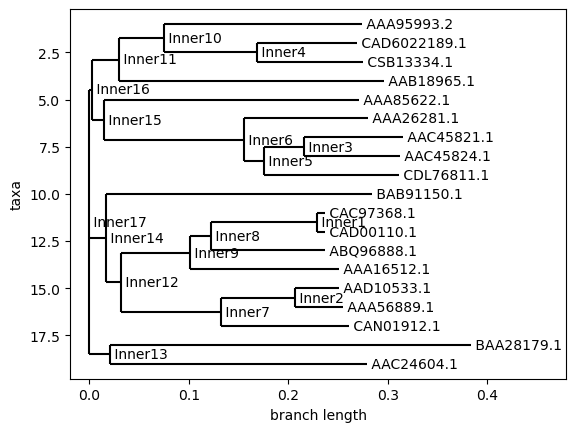

In [12]:
fig = Phylo.draw(ftsZ_tree)

This is a bit nicer, but the record ids are not very informative. For the sake of tree visualization, we will change record ids to species names:

In [26]:
names_list = [] #Create and empty list to store node names (to avoid duplicates)
for record in align: #Loop through records
    strain_name = record.description.split("[") #Split the description with the opening square bracket
    strain_name = strain_name[1] #Take the second element of the resulting list (strain name)
    strain_name = strain_name.strip("]") #Remove the closing brackets
    strain_name = strain_name.replace("(", "{")
    strain_name = strain_name.replace(")", "}")
    if strain_name in names_list: #Conditional statement to modify duplicate names
        names_list.append(strain_name) #Add strain name to list again
        strain_name += f" {names_list.count(strain_name) + 1}" #Add the number of times the sequence is present + 1 (current) to the name
    else:
        names_list.append(strain_name) #Add strain name to list
    record.id = strain_name
    print(record.id)

Agrobacterium tumefaciens
Sinorhizobium meliloti
Brucella canis str. Oliveri
Clavibacter michiganensis subsp. michiganensis NCPPB 382
Chlamydomonas reinhardtii
Neisseria gonorrhoeae
Staphylococcus aureus
Thermotoga maritima
Streptomyces griseus
Sinorhizobium meliloti 3
Bacillus subtilis subsp. spizizenii ATCC 6633 = JCM 2499
Streptomyces coelicolor A3{2}
Vibrio cholerae
Listeria monocytogenes EGD-e
Listeria innocua Clip11262
Borreliella burgdorferi
Pseudomonas aeruginosa PAO1
Porphyromonas gingivalis
Escherichia coli


Now we re-run and draw the tree again:

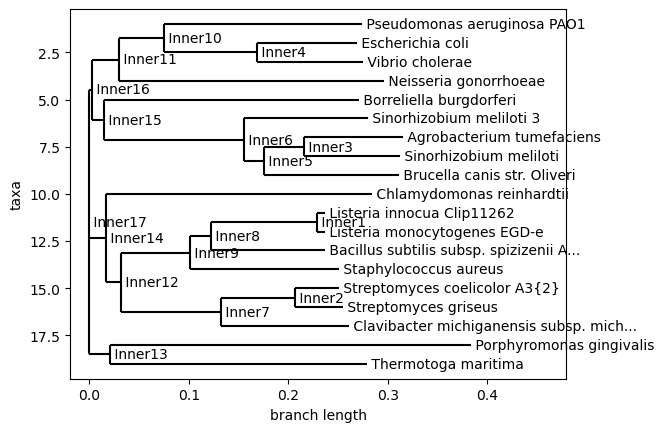

In [27]:
ftsZ_tree = constructor.build_tree(align)
fig = Phylo.draw(ftsZ_tree)

### This is great, but... what am I looking at?
This is not a great tree, as you can see the two sequences from _S. meliloti_ don't cluster together, what suggests that these two genes could be paralogs. Even so, most species that belong to the same genus (_Streptomyces_, _Listeria_) have clustered together, and _S. meliloti_ has clustered together with _A. tumefaciens_, that belongs to the same family. The clustering of _A. tumefaciens_ and _S. meliloti_ with _Brucella_ doesn't make any sense phylogenetically speaking, but as I mention the gene could be the same paralog (these three sequences were 550-600 amino acids long, as opposed to the rest that were ~400 amino acids long).

Phylogenetic relationships are always complicated. We don't only have the problem of **paralogs** (copies of the same gene in a genome that can have evolved idependently), but also events of **horizontal gene transfer (HGT)**, where different species of bacteria can exchange genetic material. Not to mention that some genes can change a lot after **speciation events**, for example, when a parasite adapts to a new host. In general, single-gene trees like this one are not reliable predicting the true phylogenetic relationship between two organisms.

You should also keep in mind that this tree is **unrooted**, which means that the sequences at the root (_P. gingivalis_ and _T. maritima_) are not necessarily the most early divergent. Not to mention that there is a trifurcation at the root of the phylogeny, instead of a bifurcation. That means that the node is unresolved.

Now let's look more in depth into the data itself. Like with SeqIO, we can use the Phylo module to read (Phylo.read for single trees and Phylo.parse for multiple trees) or to write trees, as we can see in the cell below:

In [29]:
Phylo.write(ftsZ_tree, "ftsZ.nex", "nexus") #Write tree file in nexus format

with open("ftsZ.nex") as nexus: #Open the file
    for line in nexus: #Loop through file
        print(line) #Print content of file

#NEXUS

Begin Taxa;

 Dimensions NTax=19;

 TaxLabels Pseudomonas aeruginosa PAO1 Escherichia coli Vibrio cholerae Neisseria gonorrhoeae Borreliella burgdorferi Sinorhizobium meliloti 3 Agrobacterium tumefaciens Sinorhizobium meliloti Brucella canis str. Oliveri Chlamydomonas reinhardtii Listeria innocua Clip11262 Listeria monocytogenes EGD-e Bacillus subtilis subsp. spizizenii ATCC 6633 = JCM 2499 Staphylococcus aureus Streptomyces coelicolor A3{2} Streptomyces griseus Clavibacter michiganensis subsp. michiganensis NCPPB 382 Porphyromonas gingivalis Thermotoga maritima;

End;

Begin Trees;

 Tree tree1=(((('Pseudomonas aeruginosa PAO1':0.19915,('Escherichia coli':0.10004,'Vibrio cholerae':0.10666)Inner4:0.09351)Inner10:0.04570,'Neisseria gonorrhoeae':0.26671)Inner11:0.02694,('Borreliella burgdorferi':0.25567,('Sinorhizobium meliloti 3':0.12469,(('Agrobacterium tumefaciens':0.09973,'Sinorhizobium meliloti':0.09630)Inner3:0.03948,'Brucella canis str. Oliveri':0.13532)Inner5:0.02072)Inne

This is how the nexus format looks like: it contains node names and, next to the names, branch lengths. This is not "good practice". If we want to show a phylogenetic tree, we should also show **bootstrap support values** for the branches, but this toy example illustrates how the information is stored.

If we want to generate a tree object from a file, we just have to use the Phylo.read function:

In [30]:
new_tree = Phylo.read("ftsZ.nex", "nexus")
print(new_tree)

Tree(name='tree1', rooted=False, weight=1.0)
    Clade(branch_length=0.0, name='Inner17')
        Clade(branch_length=0.00247, name='Inner16')
            Clade(branch_length=0.02694, name='Inner11')
                Clade(branch_length=0.0457, name='Inner10')
                    Clade(branch_length=0.19915, name=''Pseudomonas aeruginosa PAO1'')
                    Clade(branch_length=0.09351, name='Inner4')
                        Clade(branch_length=0.10004, name=''Escherichia coli'')
                        Clade(branch_length=0.10666, name=''Vibrio cholerae'')
                Clade(branch_length=0.26671, name=''Neisseria gonorrhoeae'')
            Clade(branch_length=0.01254, name='Inner15')
                Clade(branch_length=0.25567, name=''Borreliella burgdorferi'')
                Clade(branch_length=0.14018, name='Inner6')
                    Clade(branch_length=0.12469, name=''Sinorhizobium meliloti 3'')
                    Clade(branch_length=0.02072, name='Inner5')
         